##**Intro**

In [1]:
# !pip install -U pandas-profiling
!pip install stargazer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd

from pathlib import Path

import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True) 

import plotly.io as pi
pi.renderers.default = "colab"

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols

import plotly.express as px

# from ydata_profiling import ProfileReport
# from ydata_profiling.utils.cache import cache_file

import numpy as np
import statsmodels.formula.api as smf

from scipy.stats import skew, pearsonr,  f as f_dist
import sklearn.metrics as skm
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from stargazer.stargazer import Stargazer


In [3]:
def load_df(path):
    """
    Load a DataFrame from a CSV file.

    Args:
        path (str): The file path of the CSV file.

    Returns:
        pandas.DataFrame: The loaded DataFrame.
    """

    # read the CSV file into a DataFrame
    df = pd.read_csv(path)
    return df


In [4]:
df_survey_2022 = load_df("survey_results_public2022.csv")

In [5]:
selected_vars = ["ConvertedCompYearly" ,"RemoteWork", "EdLevel", "YearsCodePro", "MainBranch", "Employment", "OrgSize", "Country", "LanguageHaveWorkedWith", "Age", "Gender"]

In [6]:
df_survey_2022 = df_survey_2022[selected_vars]

In [7]:
df_survey_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73268 entries, 0 to 73267
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ConvertedCompYearly     38071 non-null  float64
 1   RemoteWork              58958 non-null  object 
 2   EdLevel                 71571 non-null  object 
 3   YearsCodePro            51833 non-null  object 
 4   MainBranch              73268 non-null  object 
 5   Employment              71709 non-null  object 
 6   OrgSize                 51039 non-null  object 
 7   Country                 71771 non-null  object 
 8   LanguageHaveWorkedWith  70975 non-null  object 
 9   Age                     70946 non-null  object 
 10  Gender                  70853 non-null  object 
dtypes: float64(1), object(10)
memory usage: 6.1+ MB


##**Prepare data**

In this section we will:
1. Drop nan values of dependent variable
2. Leave only professional developers in the dataset
3. Leave only employed full-time, part-time, freelancer from *Employment*
4. Drop Secondary and Elementary school of *EdLevel*
5. Leave only Men and Women from *Gender*
6. Drop any other rows with nan values
7. Cut outliers
8. Drop useless data - "Prefered not to say" from *Age*

etc.

In [8]:
# filter out rows where the "ConvertedCompYearly" column is null
df_survey_2022 = df_survey_2022[df_survey_2022["ConvertedCompYearly"].notnull()]

In [9]:
# filter out rows where the "MainBranch" column is not "I am a developer by profession"
df_survey_2022 = df_survey_2022[df_survey_2022["MainBranch"] == "I am a developer by profession"]

In [10]:
# filter out rows where the "Employment" column has values other than the specified options
df_survey_2022 = df_survey_2022[df_survey_2022["Employment"].isin(["Employed, full-time",
                                          "Independent contractor, freelancer, or self-employed",
                                          "Employed, part-time",
                                          "Employed, full-time;Independent contractor, freelancer, or self-employed"])]

In [11]:
df_survey_2022 = df_survey_2022[df_survey_2022["EdLevel"].isin(['Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
                                                                'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
                                                                'Something else',
                                                                'Some college/university study without earning a degree',
                                                                'Professional degree (JD, MD, etc.)',
                                                                'Other doctoral degree (Ph.D., Ed.D., etc.)'])]

In [12]:
df_survey_2022 = df_survey_2022[df_survey_2022["Gender"].isin(["Man", "Woman"])]

In [13]:
# drop rows with any remaining null values
df_survey_2022 = df_survey_2022.dropna()

In [14]:
# remove rows where "ConvertedCompYearly" is less then 1,000
df_survey_2022 = df_survey_2022[df_survey_2022["ConvertedCompYearly"] > 500]
df_survey_2022 = df_survey_2022[df_survey_2022["ConvertedCompYearly"] < 500000]

In [15]:
# remove rows where the age is "Prefer not to say"
age_remover = df_survey_2022[df_survey_2022["Age"].isin(['Prefer not to say'])].index
df_survey_2022 = df_survey_2022.drop(age_remover)

In [16]:
def exper_fix(x):
    """
    Fix the format of experience values.

    Args:
        x (str): The experience value.

    Returns:
        float or str: The fixed experience value.
    """

    if x == 'More than 50 years':
        return 50
    elif x == 'Less than 1 year':
        return 0.5
    else:
        return x

def onsite_mapping(x):
    """
    Map onsite work options to numerical values.

    Args:
        x (str): The onsite work option.

    Returns:
        int: The mapped numerical value.
    """
    
    if 'Fully remote' in x:
        return 0
    elif 'Hybrid' in x:
        return 1
    elif 'Full in-person' in x:
        return 2

def gender_mapping(x):
    
    if 'Man' in x:
        return 0
    else:
        return 1


In [17]:
def split_cols(df):
    df_res = df.to_frame()
    options = []
    for i, value in df[df.notnull()].items():
        option_list = value.split(';')
        for option in option_list:
            if not option in df_res.columns:
                options.append(option)
                df_res[option] = 0
            df_res.at[i, option] = 1
    return df_res[options]

In [18]:
def encode_vars(df):

    # dummy variable for educational level
    ed_level = split_cols(df["EdLevel"])
    df = pd.concat([df, ed_level], axis=1)
    df = df.drop(["EdLevel"], axis=1)

    # dev_type = split_cols(df["DevType"])
    # dev_type_sum = dev_type.sum()
    # keep_col = dev_type_sum[dev_type_sum.values >= 1000].index
    # # concatenate dev_type columns to the DataFrame
    # df = pd.concat([df, dev_type[keep_col]], axis=1)
    # # drop the original "DevType" column
    # df = df.drop(["DevType"], axis=1)

    # apply exper_fix function to "YearsCodePro" column
    df["YearsCodePro"] = df["YearsCodePro"].apply(exper_fix)
    df["YearsCodePro"] = df["YearsCodePro"].astype(float)

    language = split_cols(df["LanguageHaveWorkedWith"])
    language_sum = language.sum()
    keep_language = language_sum[language_sum.values >= 3000].index
    # concatenate language columns to the DataFrame
    df = pd.concat([df, language[keep_language]], axis=1)

    # drop unnecessary columns
    df = df.drop(["LanguageHaveWorkedWith", "Employment", "MainBranch"], axis=1)

    # dummy variable for "Age" column
    age_type = split_cols(df["Age"])
    df = pd.concat([df, age_type], axis=1)
    df = df.drop(["Age"], axis=1)

    # remove rows where the organization size is "I don’t know"
    org_size_index_remove = df[df["OrgSize"].isin(['I don’t know'])].index
    df = df.drop(org_size_index_remove)

    # dummy variable for educational level
    org_size = split_cols(df["OrgSize"])
    df = pd.concat([df, org_size], axis=1)
    df = df.drop(["OrgSize"], axis=1)

    # apply onsite_mapping function to "RemoteWork" column
    df["RemoteWork"] = df["RemoteWork"].apply(onsite_mapping)

    country = split_cols(df["Country"])
    country_sum = country.sum()
    keep_country = list(country_sum[country_sum.values >= 500].index) + list(country_sum[country_sum.values == 228].index)
    # concatenate country columns to the DataFrame
    df = pd.concat([df, country[keep_country]], axis=1)
    df = df.drop("Country", axis=1)

    df["Gender"] = df["Gender"].apply(gender_mapping)

    return df


In [19]:
df_survey_2022 = encode_vars(df_survey_2022)

<ipython-input-17-bd8e1f147dd0>:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-17-bd8e1f147dd0>:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-17-bd8e1f147dd0>:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-17-bd8e1f147dd0>:9: PerformanceWarning:

Da

Here is the resulting prepared dataset:

In [20]:
df_survey_2022

,ConvertedCompYearly,RemoteWork,YearsCodePro,Gender,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Something else,Some college/university study without earning a degree,"Professional degree (JD, MD, etc.)","Other doctoral degree (Ph.D., Ed.D., etc.)",...,Italy,Canada,Germany,Poland,Netherlands,Brazil,France,Spain,India,Australia
3,215232.0,0,17.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,60307.0,1,2.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,65000.0,1,5.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,110000.0,0,5.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,19224.0,1,4.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73112,52255.0,1,3.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73113,94000.0,0,5.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73116,115000.0,1,16.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73118,57720.0,0,3.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here we will rename some columns for more convinient performance.

In [21]:
df_survey_2022.rename(columns={"Bachelor’s degree (B.A., B.S., B.Eng., etc.)": "isBachelor", 
                               "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": "isMaster",
                               "Professional degree (JD, MD, etc.)": "isProfessional",
                               "Other doctoral degree (Ph.D., Ed.D., etc.)": "hasPhD",
                               "Something else": "noDegree",
                               "100 to 499 employees": "emp_100_499",
                               "2 to 9 employees": "emp_2_9",
                               "5,000 to 9,999 employees": "emp_5k_10k",
                               "1,000 to 4,999 employees": "emp_1k_5k",
                               "20 to 99 employees": "emp_20_99",
                               "10,000 or more employees": "emp_10k_plus",
                               "500 to 999 employees": "emp_500_1k",
                               "10 to 19 employees": "emp_10_19",
                               "Just me - I am a freelancer, sole proprietor, etc.": "solo_emp",
                               "Some college/university study without earning a degree": "dropOutUni",
                               "35-44 years old": "age_35_44",
                               "18-24 years old": "age_18_24",
                               "25-34 years old": "age_25_34",
                               "55-64 years old": "age_55_64",
                               "45-54 years old": "age_45_54",
                               "65 years or older": "age_65_plus",
                               "Under 18 years old": "age_under_18",
                               "United Kingdom of Great Britain and Northern Ireland": "UK",
                               "United States of America": "USA",
                               "C#": "C_sharp",
                               "C++": "C_pp",
                               "Bash/Shell": "Bash_Shell",
                               "HTML/CSS": "HTML_CSS"}, errors="raise", inplace=True)


##**Linear Model**

To perform the construction of the fully significant linear regression model we will use backward elimination method (construct model and exclude unsignificant parts according to the highest p-values of dependent variables) with significance level = 0.05 (series of t-tests).

In [22]:
def construct_lr_model(df, dependent_var):

  # independent variables
  all_vars = np.array(pd.Series(df.columns.drop("ConvertedCompYearly")).array).tolist()
  formula_vars = ' + '.join(all_vars)

  # construct linear model
  lr_moded_all = smf.ols(formula = f'{dependent_var} ~ {formula_vars}', data=df_survey_2022)
  lr_moded_all = lr_moded_all.fit()
  
  return lr_moded_all


In [23]:
def interpret_results(all_variables, categorical_variables, coefficients, logM=False):

  print("Interpretation of the model:\n")
  
  print(f"Intercept of the model is {coefficients[0]}")

  for var, coeff in zip(all_variables, np.array(coefficients[1:])):

    if var in categorical_variables:

      if logM:
        print(f"If {var} = 1, then on average yearly salary would increase by {coeff*100} %, keeping all other factors fixed.")
      else:
        print(f"If a person is {var} ({var} = 1), then on average yearly salary would increase by {coeff}, keeping all other factors fixed.")

    else:

      if logM:
        print(f"One unit increase in {var}, would on average change yearly salary by {coeff*100} %, keeping all other factors fixed.")
      else:
        print(f"One unit increase in {var}, would on average change yearly salary by {coeff}, keeping all other factors fixed.")


In [24]:
significance_level = 0.05

# implement backward elimination
def backward_elimination(sl, dependent_var, selected_columns, iteration_no):

  formula = ' + '.join(selected_columns)

  # fitting variables into the model
  current_model = smf.ols(formula = f'{dependent_var} ~ {formula}', data=df_survey_2022)
  current_model = current_model.fit() 
  print(f"Iteration #{iteration_no}. {formula_util(current_model, selected_columns, dependent_var)}")

  # highest p-value in the model among all variables
  curr_max_pval = max(current_model.pvalues)
  var_highest_pval = current_model.pvalues.idxmax(axis=0)

  # track if it is needed to run the model further (step 5)
  repeat = False

  # check if the highest p-value is bigger then significance level
  # if so, delete this variable
  if curr_max_pval > significance_level:
    selected_columns.remove(var_highest_pval)
    repeat = True
    print(f"R-squared of the model: {current_model.rsquared}")
    print(f"Adjusted R-squared of the model: {current_model.rsquared_adj}")
    print(f"Variable {var_highest_pval} with p-value {curr_max_pval} > {significance_level} is dropped from the model.\n")


  return repeat, selected_columns, current_model

In [25]:
# display the model equation
def formula_util(model, variables, dep_var):
  
  intercept = model.params[0]
  coeff_vars = list(zip(model.params[1:], variables))

  str_model = f"{dep_var} = {intercept} + "

  for i in range(len(coeff_vars)):
    coeff, var = coeff_vars[i][0], coeff_vars[i][1]
    str_model += f"({str(coeff)}) * {var}"
    if i != len(coeff_vars)-1:
      str_model += " + "

  return str_model

For right performance we should drop the variables of the base groups.

In [26]:
df_for_modeling = df_survey_2022.drop(["dropOutUni", "PowerShell", "age_under_18", "solo_emp", "Brazil"], axis=1)
model1 = construct_lr_model(df_for_modeling, "ConvertedCompYearly")
print(model1.summary())

                             OLS Regression Results                            
Dep. Variable:     ConvertedCompYearly   R-squared:                       0.426
Model:                             OLS   Adj. R-squared:                  0.425
Method:                  Least Squares   F-statistic:                     470.2
Date:                 Tue, 23 May 2023   Prob (F-statistic):               0.00
Time:                         16:59:27   Log-Likelihood:            -3.5130e+05
No. Observations:                28522   AIC:                         7.027e+05
Df Residuals:                    28476   BIC:                         7.031e+05
Df Model:                           45                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       4.673e+04   3.13e+

As we can see, some of the dependent variables are statistically insignificant, so we will exclude them one-by-one by the highest p-value.

And there are strong multicollinearity.

Let's see if we can get rid of those problems, with backward elimination method.

In [27]:
# variables for current lr model
selected_vars = df_for_modeling.columns.drop(["ConvertedCompYearly"]).to_list()

iteration_no = 1
repeat, selected_vars, final_model = backward_elimination(significance_level, 'ConvertedCompYearly', selected_vars, iteration_no)

while repeat:
  iteration_no += 1
  # print(selected_vars)
  repeat, selected_vars, final_model = backward_elimination(significance_level, 'ConvertedCompYearly', selected_vars, iteration_no)

Iteration #1. ConvertedCompYearly = 46734.428594534584 + (-3831.093056249198) * RemoteWork + (2402.1035708394106) * YearsCodePro + (-7262.030375770222) * Gender + (979.1015415349879) * isBachelor + (8433.191539012794) * isMaster + (4364.9696010561065) * noDegree + (949.6963279416735) * isProfessional + (16790.744978725514) * hasPhD + (-7195.901798194209) * C_sharp + (-2110.5176682984375) * JavaScript + (-3045.259489650001) * SQL + (8082.338299896731) * TypeScript + (3364.8583612444495) * Bash_Shell + (-5936.127179315035) * HTML_CSS + (-2401.3813453944394) * C + (-9669.84479450602) * PHP + (3747.3176674382794) * Python + (1575.7055263737132) * Java + (14031.062262509078) * Go + (2219.354417325435) * C_pp + (617.9877036635035) * age_35_44 + (-10699.114831317991) * age_18_24 + (311.83619727996336) * age_25_34 + (-39645.57362253901) * age_55_64 + (-15605.302683912469) * age_45_54 + (-75870.74818566133) * age_65_plus + (-7512.134281055914) * emp_100_499 + (-15429.03122756444) * emp_2_9 + (7

After 10 iterations (9 excluded variables) we receive the final significant model without multicolinearity, that was in the beginning.

In [28]:
print(final_model.summary())

                             OLS Regression Results                            
Dep. Variable:     ConvertedCompYearly   R-squared:                       0.426
Model:                             OLS   Adj. R-squared:                  0.425
Method:                  Least Squares   F-statistic:                     587.5
Date:                 Tue, 23 May 2023   Prob (F-statistic):               0.00
Time:                         16:59:33   Log-Likelihood:            -3.5130e+05
No. Observations:                28522   AIC:                         7.027e+05
Df Residuals:                    28485   BIC:                         7.030e+05
Df Model:                           36                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4.752e+04   1253.892    

In [29]:
intercept = [final_model.params[0]]
vars_sorted_by_coeff = [i for i in final_model.params[1:].sort_values(ascending=False).index.to_list()]

Here is the interpretation of every independent variable in the final model.

In [30]:
categorical_vars = vars_sorted_by_coeff.copy()
categorical_vars.remove('YearsCodePro')
interpret_results(vars_sorted_by_coeff, 
                  categorical_vars,
                  intercept + final_model.params[1:].sort_values(ascending=False).reset_index()[0].tolist())

Interpretation of the model:

Intercept of the model is 47522.19604964325
If a person is USA (USA = 1), then on average yearly salary would increase by 90231.78764922865, keeping all other factors fixed.
If a person is Canada (Canada = 1), then on average yearly salary would increase by 39423.96958096714, keeping all other factors fixed.
If a person is Australia (Australia = 1), then on average yearly salary would increase by 37419.95599051172, keeping all other factors fixed.
If a person is UK (UK = 1), then on average yearly salary would increase by 34351.519862857676, keeping all other factors fixed.
If a person is Netherlands (Netherlands = 1), then on average yearly salary would increase by 16454.41154948219, keeping all other factors fixed.
If a person is hasPhD (hasPhD = 1), then on average yearly salary would increase by 16239.76168999512, keeping all other factors fixed.
If a person is Germany (Germany = 1), then on average yearly salary would increase by 14525.120971865836, k

Here is the equation of the final model.

In [31]:
formula_model1 = formula_util(final_model,
             final_model.params.reset_index()['index'][1:].to_list(),
             "ConvertedCompYearly")

print(formula_model1)

ConvertedCompYearly = 47522.19604964325 + (-3735.6602439229328) * RemoteWork + (2413.631317854095) * YearsCodePro + (-7233.314295695078) * Gender + (7799.852537508527) * isMaster + (16239.76168999512) * hasPhD + (-7222.690291828822) * C_sharp + (-2115.2785410962993) * JavaScript + (-3042.895880891153) * SQL + (8075.4554557093725) * TypeScript + (3367.133505821547) * Bash_Shell + (-5880.74556829035) * HTML_CSS + (-2369.8598768830775) * C + (-9607.600992320184) * PHP + (3717.1414385845483) * Python + (1609.4143114123437) * Java + (13974.310185961587) * Go + (2205.4339593671343) * C_pp + (-10953.380885124167) * age_18_24 + (-40322.4931934897) * age_55_64 + (-16193.250405465698) * age_45_54 + (-76792.4792323494) * age_65_plus + (-7299.028430510267) * emp_100_499 + (-15190.14708662534) * emp_2_9 + (-10446.645715843168) * emp_20_99 + (5824.953969428021) * emp_10k_plus + (-4511.057037223453) * emp_500_1k + (-11692.573904663184) * emp_10_19 + (34351.519862857676) * UK + (90231.78764922865) * U

###**Prediction**

In [32]:
X = df_for_modeling.iloc[:, 1:]
y = df_for_modeling.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_test_pred = linreg.predict(X_test)
r2 = r2_score(y_test, y_test_pred)

print(f"Mean absolute error of linear regression model: {round(skm.mean_absolute_error(y_test, y_test_pred), 2)}")
print("R-squared:", r2)

Mean absolute error of linear regression model: 33348.39
R-squared: 0.4350709308710953


As we can see the $R^2$ is 43.5%, which means that the predicted data is accurate in 43.5%. (the goodness depends on the situation)

From the resulting value of MAE we can see, that the average absolute error is not very small = \~33000 (as the mean value of salary in the dataset is \~130000)

<ipython-input-33-48540f6427d0>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-33-48540f6427d0>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




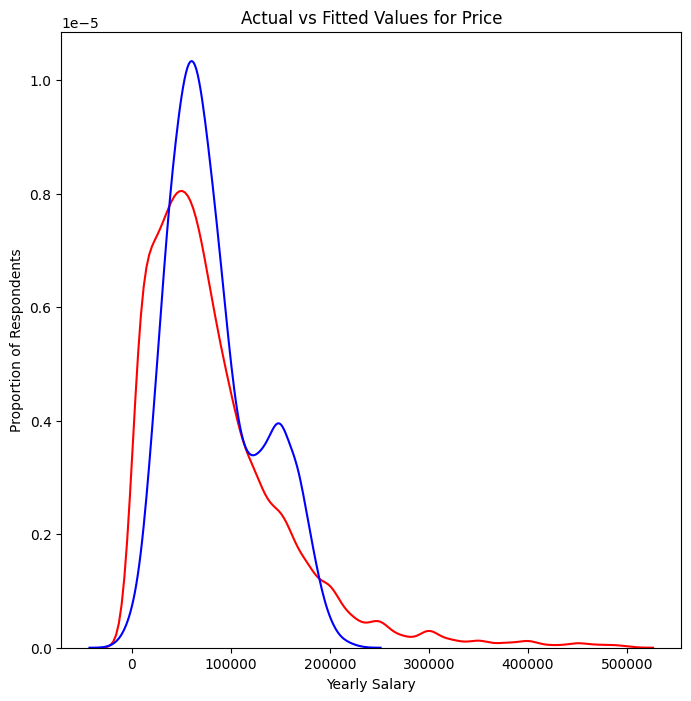

In [33]:
plt.figure(figsize=(8, 8))

ax1 = sns.distplot(df_for_modeling['ConvertedCompYearly'], hist=False, color="r", label="Actual Value")
sns.distplot(y_test_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Yearly Salary')
plt.ylabel('Proportion of Respondents')

plt.show()
plt.close()

As we can see from this graph, the predicted data (blue color), has quite simular distribution as the original data.

We can conclude that the fitted values are reasonably close to the actual values, since the two distributions overlap a bit. However, there is definitely some room for improvement.

##**Log-Level Model**

To perform Log-Level model we will logarithmize the dependent variable *ConvertedCompYearly*.

In [34]:
df_survey_2022["lsalary"] = np.log(df_survey_2022.ConvertedCompYearly)
df_for_modeling["lsalary"] = np.log(df_survey_2022.ConvertedCompYearly)

In [35]:
selected_vars_2 = " + ".join(df_for_modeling.columns.drop(["ConvertedCompYearly", "lsalary"]).to_list())

# construc log-linear regression
logl_model = smf.ols(formula = f'lsalary ~ {selected_vars_2}', data=df_survey_2022)
logl_model = logl_model.fit()
print(logl_model.summary())

                            OLS Regression Results                            
Dep. Variable:                lsalary   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     675.2
Date:                Tue, 23 May 2023   Prob (F-statistic):               0.00
Time:                        16:59:36   Log-Likelihood:                -30102.
No. Observations:               28522   AIC:                         6.030e+04
Df Residuals:                   28476   BIC:                         6.068e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          9.9661      0.403     24.

As we can see, some of the dependent variables are statistically insignificant, so we will exclude them one-by-one by the highest p-value. But in comparicing to linear model, the number of significant variables are a bit smaller.

And there are strong multicollinearity too.

Let's see if we can get rid of those problems, with backward elimination method and how many iteration of elimination should we perform.

In [36]:
selected_vars = df_for_modeling.columns.drop(["ConvertedCompYearly", "lsalary"]).to_list()

iteration_no = 1
repeat, selected_vars, logl_model_fin = backward_elimination(significance_level, 'lsalary', selected_vars, iteration_no)

while repeat:
  iteration_no += 1
  # print(selected_vars)
  repeat, selected_vars, logl_model_fin = backward_elimination(significance_level, 'lsalary', selected_vars, iteration_no)

Iteration #1. lsalary = 9.96610828521872 + (-0.09339526108727554) * RemoteWork + (0.036314858286942316) * YearsCodePro + (-0.07071342679080046) * Gender + (0.01062265642273438) * isBachelor + (0.14516644476194682) * isMaster + (0.03660552367185533) * noDegree + (-0.0821741598434255) * isProfessional + (0.1954174144557974) * hasPhD + (-0.06441032190560711) * C_sharp + (-0.04582777538152298) * JavaScript + (-0.023270550779550224) * SQL + (0.15324225119154353) * TypeScript + (0.08942083957994158) * Bash_Shell + (-0.08079620522386242) * HTML_CSS + (-0.0410824818775065) * C + (-0.22146626867822547) * PHP + (0.056087937873319976) * Python + (-0.009873297530684631) * Java + (0.16847870012034383) * Go + (0.0017242971306244202) * C_pp + (0.2937257616943479) * age_35_44 + (-0.06804209225299085) * age_18_24 + (0.2916065804927386) * age_25_34 + (-0.289880172908873) * age_55_64 + (0.039193340079594026) * age_45_54 + (-0.8147392679201415) * age_65_plus + (0.10349161653896355) * emp_100_499 + (-0.147

After 7 iterations (6 excluded variables) we receive the final significant model without multicolinearity, that was in the beginning.

As expected , the number of excluded variables is smaller as in linear model, which means, that the Log-Level fits data a bit better.

In [37]:
# display final log-linear model
print(logl_model_fin.summary())

                            OLS Regression Results                            
Dep. Variable:                lsalary   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     779.0
Date:                Tue, 23 May 2023   Prob (F-statistic):               0.00
Time:                        16:59:40   Log-Likelihood:                -30104.
No. Observations:               28522   AIC:                         6.029e+04
Df Residuals:                   28482   BIC:                         6.062e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.0359      0.029    345.

In [38]:
intercept = [logl_model_fin.params[0]]
vars_sorted_by_coeff_log = [i for i in logl_model_fin.params[1:].sort_values(ascending=False).index.to_list()]

Here is the interpretation of every dependent variable in the final model.

In [39]:
categorical_vars = vars_sorted_by_coeff_log.copy()
categorical_vars.remove("YearsCodePro")
interpret_results(vars_sorted_by_coeff_log, categorical_vars, intercept + logl_model_fin.params[1:].sort_values(ascending=False).reset_index()[0].to_list(), logM=True)

Interpretation of the model:

Intercept of the model is 10.035912501933542
If USA = 1, then on average yearly salary would increase by 115.71713772127438 %, keeping all other factors fixed.
If Australia = 1, then on average yearly salary would increase by 78.9561140966953 %, keeping all other factors fixed.
If Canada = 1, then on average yearly salary would increase by 76.91730505036662 %, keeping all other factors fixed.
If UK = 1, then on average yearly salary would increase by 67.4388043091231 %, keeping all other factors fixed.
If Netherlands = 1, then on average yearly salary would increase by 53.85663377443994 %, keeping all other factors fixed.
If Germany = 1, then on average yearly salary would increase by 52.881312712047645 %, keeping all other factors fixed.
If France = 1, then on average yearly salary would increase by 31.823366418892164 %, keeping all other factors fixed.
If Spain = 1, then on average yearly salary would increase by 25.818915816233467 %, keeping all other f

Here is the equation of the final model.

In [40]:
formula_log_model_formula = formula_util(logl_model_fin,
             logl_model_fin.params.reset_index()['index'][1:].to_list(),
             "lsalary")

print(formula_log_model_formula)

lsalary = 10.035912501933542 + (-0.0925355255701672) * RemoteWork + (0.03620576837111127) * YearsCodePro + (-0.0699966922563749) * Gender + (0.13601888418430014) * isMaster + (-0.09147814829815172) * isProfessional + (0.18711651001386503) * hasPhD + (-0.06330880733952439) * C_sharp + (-0.04653740135121775) * JavaScript + (-0.02434195683762854) * SQL + (0.15325436227668404) * TypeScript + (0.0890260030215446) * Bash_Shell + (-0.08076598772298639) * HTML_CSS + (-0.041594457980386766) * C + (-0.22199513341992888) * PHP + (0.05615512336645101) * Python + (0.16795572481921253) * Go + (0.25489663472620533) * age_35_44 + (-0.1076517606993786) * age_18_24 + (0.2529139834562683) * age_25_34 + (-0.32867851025968065) * age_55_64 + (-0.8559621529312993) * age_65_plus + (0.0797132705723732) * emp_100_499 + (-0.17031555649136274) * emp_2_9 + (0.19510232688640672) * emp_5k_10k + (0.15870211416225488) * emp_1k_5k + (0.21194316516256645) * emp_10k_plus + (0.11692642800479183) * emp_500_1k + (-0.0697571

###**Prediction**

In [41]:
X = df_for_modeling.iloc[:, 1:-1]
y = df_for_modeling.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_test_pred = linreg.predict(X_test)

r2 = r2_score(y_test, y_test_pred)

print(f"Mean absolute error of linear regression model: {round(skm.mean_absolute_error(y_test, y_test_pred), 2)}")

print("R-squared:", r2)

Mean absolute error of linear regression model: 0.49
R-squared: 0.5093678793802078


As we can see the $R^2$ is 50.9%, which means that the predicted data is accurate in 50.9%. (the goodness depends on the situation)

From the resulting value of MAE we can see, that the average absolute error is quite small = \~0.49 (as the mean value of salary in the dataset is \~10.9)

<ipython-input-42-9bb74e699a82>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-42-9bb74e699a82>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




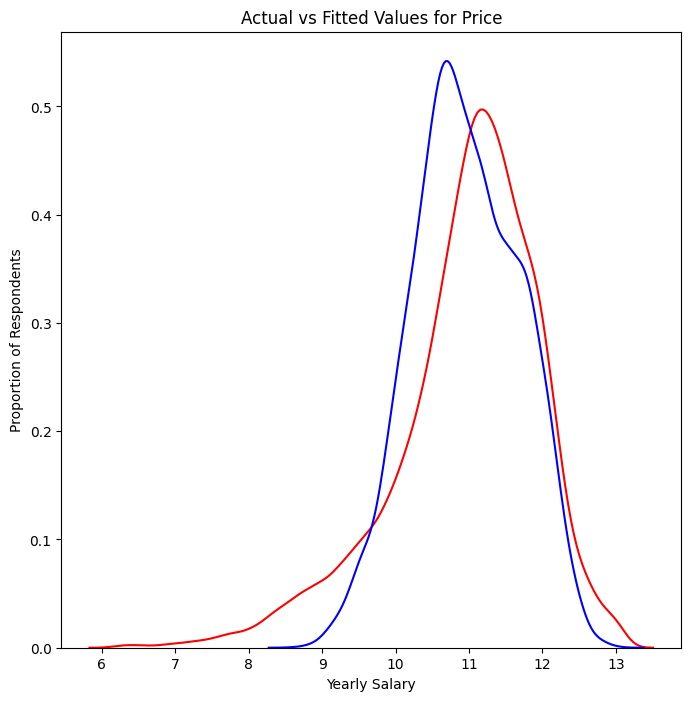

In [42]:
plt.figure(figsize=(8, 8))

ax1 = sns.distplot(df_for_modeling['lsalary'], hist=False, color="r", label="Actual Value")
sns.distplot(y_test_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Yearly Salary')
plt.ylabel('Proportion of Respondents')

plt.show()
plt.close()

We can see that the predicted values are quite close to the actual values and the 2 distributions are almost fully overlaping.

##**F-test**

Now let's perform the F-test. We want to test:
* if the factor of organization/company size has significant effect on the salary
* if the factor of country, where the person works has significant effect on the salary
* if the factor of age, of the person has significant effect on the salary
* if the factor of format of work and gender, of the person have significant joint effect on the salary

There will be such hypotheses:

* $H_0$ - insignificant

* $H_1$ - significant

In [43]:
formula_size = 'ConvertedCompYearly ~ emp_100_499 + emp_2_9 + emp_5k_10k + emp_1k_5k + emp_20_99 + emp_10k_plus + emp_500_1k + emp_10_19'

In [44]:
model = ols(formula_size, data=df_for_modeling).fit()

# Perform the F-test
f_value = model.fvalue
p_value = model.f_pvalue

# Print the results
print("F-value:", f_value)
print("P-value:", p_value)

F-value: 147.81064501646887
P-value: 7.849653384190407e-245


As we can see, the p-value is very small, so we can reject the $H_0$. Therefore we can say, that indeed the size of organization is a significant factor for determining the salary of the worker.

In [45]:
formula_country = 'ConvertedCompYearly ~ UK + USA + Italy + Canada + Germany + Poland + Netherlands + France + Spain + India + Australia'

In [46]:
model = ols(formula_country, data=df_for_modeling).fit()

# Perform the F-test
f_value = model.fvalue
p_value = model.f_pvalue

# Print the results
print("F-value:", f_value)
print("P-value:", p_value)

F-value: 1296.217272247968
P-value: 0.0


From this test, we can see, that the country, where the person works is also a significant information factor for determining the amount of salary.

In [47]:
formula_age = 'ConvertedCompYearly ~ age_35_44 + age_18_24 + age_25_34 + age_55_64 + age_45_54 + age_65_plus'

In [48]:
model = ols(formula_age, data=df_for_modeling).fit()

# Perform the F-test
f_value = model.fvalue
p_value = model.f_pvalue

# Print the results
print("F-value:", f_value)
print("P-value:", p_value)

F-value: 421.7745850662928
P-value: 0.0


The group of dummy variables representing the age of the person, appear to be also significant for the model.

In [49]:
formula_single = 'ConvertedCompYearly ~ RemoteWork + Gender'

In [50]:
model = ols(formula_single, data=df_for_modeling).fit()

# Perform the F-test
f_value = model.fvalue
p_value = model.f_pvalue

# Print the results
print("F-value:", f_value)
print("P-value:", p_value)

F-value: 433.7705279097798
P-value: 2.6566830946502103e-186


And lastly, the joint significance of the format of the work and the gender of the person if proved to be true. Therefore we can conclude that those two factors are jointly significant for the model to determine the amount of salary.

**Thank you!**